### Dimensionality Reduction Comparison
#### PCA, t-SNE, DCA
##### 12Nov18
This is an example of the comparisons I've been testing between DR algorithms, using a subset of the first dataset I was given by Bob.  This particular set has a 0.00 "closeness" score, which means it should be easily clustered based on principal components.  There are 375 cells and ~25000 genes. 

In [1]:
import numpy as np
import scipy as sc

# package for reading in data files
import h5py

# scikit packages
import skbio
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# import tsne packages
from sklearn.manifold import TSNE

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')
%matplotlib inline

Define function to read in *.hdf5* files

In [2]:
def read_hdf5(filename):
    '''read in all replicates in an .hdf5 file'''
    hdf5in = h5py.File(filename, 'r')
    hdf5out = {} # initialize empty dictionary
    for key in list(hdf5in.keys()):
        hdf5out.update({key:hdf5in[key].value})
        
    hdf5in.close()
    return hdf5out

Define functions for normalizing and transforming raw counts data

In [3]:
def arcsinh_norm(x, norm = True, scale = 1000):
    '''
    Perform an arcsinh-transformation on a np.ndarray containing raw data of shape=(n_cells,n_genes).
    Useful for feeding into PCA or tSNE.
        norm = convert to fractional counts first? divide each count by sqrt of sum of squares of counts for cell.
        scale = factor to multiply values by before arcsinh-transform. scales values away from [0,1] in order to make arcsinh more effective.
    '''
    if not norm:
        return np.arcsinh(x * scale)
    
    else:
        return np.arcsinh(normalize(x, axis=0, norm='l2') * scale)
    
def log2_norm(x, norm = True):
    '''
    Perform a log2-transformation on a np.ndarray containing raw data of shape=(n_cells,n_genes).
    Useful for feeding into PCA or tSNE.
        norm = convert to fractional counts first? divide each count by sqrt of sum of squares of counts for cell.
    '''
    if not norm:
        return np.log2(x + 1)
    
    else:
        return np.log2(normalize(x, axis=0, norm='l2') + 1)

Define function to compare counts data before and after dimensionality reduction.  
__pre__ and __post__ matrices should be of shape *(n_cells, n_genes)*.  
This function will generate distance matrices of shape *(n_cells, n_cells)* and compare them with the following:  
* __Mantel test__ for correlation of the two matrices
* __Wasserstein__ or __"Earth-Movers Distance (EMD)"__ between the upper triangle of each distance matrix, representing all cell-cell distances
* Plot of upper triangles of each matrix, representing (n_cells^2 - n_cells)/2

In [4]:
def compare_euclid(pre, post, plot_out=True):
    '''test for correlation between Euclidean cell-cell distances before and after transformation by a function or DR algorithm'''
    # generate distance matrices for pre- and post-transformation arrays
    dm_pre = sc.spatial.distance_matrix(pre,pre)
    dm_post = sc.spatial.distance_matrix(post,post)
    
    # calculate Spearman correlation coefficient and p-value for distance matrices using Mantel test
    mantel_stats = skbio.stats.distance.mantel(x=dm_pre, y=dm_post)
    
    # for each matrix, take the upper triangle (it's symmetrical), and remove all zeros for calculating EMD and plotting distance differences
    pre_flat = np.triu(dm_pre)[np.nonzero(np.triu(dm_pre))]
    post_flat = np.triu(dm_post)[np.nonzero(np.triu(dm_post))]
    
    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat.flatten(), post_flat.flatten())
    
    if plot_out:
        plt.figure(figsize=(5,5))
        sns.scatterplot(pre_flat, post_flat, s=75, alpha=0.6)
        plt.figtext(0.95, 0.5, 'R: {}\np-val: {}\nn: {}\nEMD: {}'.format(round(mantel_stats[0],5),mantel_stats[1],mantel_stats[2],round(EMD,5)), fontsize=12)
        plt.title('Distance Correlation')
        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        plt.show()
        
    return mantel_stats, EMD

---
#### Read in example data

In [5]:
#load an hdf5 file into object
%time r00 = read_hdf5("inputs/GSE102698ClosenessRep_0.hdf5")

CPU times: user 2.48 s, sys: 465 ms, total: 2.94 s
Wall time: 3.01 s


---
#### Perform PCA
50-component analysis on arcsinh-normalized RNA-seq counts

In [6]:
%%time
# PCA with 50 PCs on arcsinh-transformed data
sinh_norm = arcsinh_norm(r00['Close_0.00'])
PCA_fit = PCA(n_components=50).fit(sinh_norm)
# transform data to fit
PCA_results = PCA_fit.transform(sinh_norm)

CPU times: user 1.19 s, sys: 174 ms, total: 1.36 s
Wall time: 811 ms


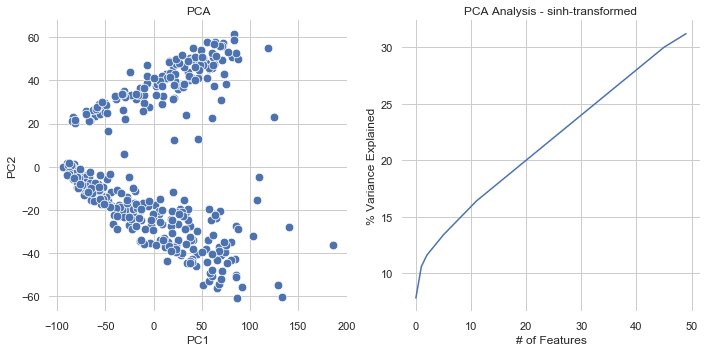

In [7]:
# Plot PCA
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(PCA_results[:,0], PCA_results[:,1], s=75)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

plt.subplot(122)
plt.plot(np.cumsum(np.round(PCA_fit.explained_variance_ratio_, decimals=3)*100))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - sinh-transformed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

Seems like there ar two distinct clusters, delineated by the value of the second principal component  
let's try to cluster them using `sklearn.cluster.KMeans`

In [8]:
# cluster PCA results using k-means
cluster_fit = KMeans(n_clusters=2, max_iter=1000).fit(PCA_results)
clusters = cluster_fit.predict(PCA_results)

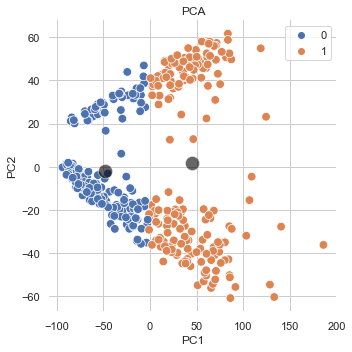

In [9]:
# Plot principal component analysis
plt.figure(figsize=(5,5))

sns.scatterplot(PCA_results[:,0], PCA_results[:,1], s=75, hue=clusters) # color plot by clusters
sns.scatterplot(cluster_fit.cluster_centers_[:,0], cluster_fit.cluster_centers_[:,1], s=200, alpha=0.6, color='black') # plot cluster centers
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.title('PCA')

sns.despine(left=True, bottom=True)
plt.tight_layout()

Let's try this again, maybe we can get it to cluster correctly on __PC2__ and __PC3__:

In [10]:
# cluster PCA results using k-means
cluster_fit = KMeans(n_clusters=2, max_iter=1000).fit(PCA_results[:,1:3])
clusters = cluster_fit.predict(PCA_results[:,1:3])

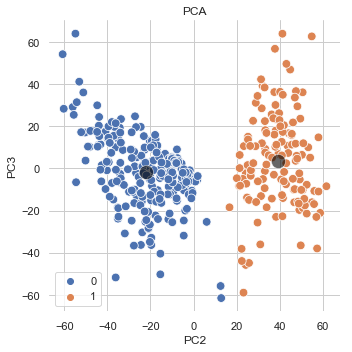

In [11]:
# Plot principal component analysis
plt.figure(figsize=(5,5))

sns.scatterplot(PCA_results[:,1], PCA_results[:,2], s=75, hue=clusters) # color plot by clusters
sns.scatterplot(cluster_fit.cluster_centers_[:,0], cluster_fit.cluster_centers_[:,1], s=200, alpha=0.6, color='black') # plot cluster centers
plt.ylabel('PC3')
plt.xlabel('PC2')
plt.title('PCA')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Perform t-SNE
Use output of 50-component PCA to prime t-SNE  
`sklearn` implementation of tSNE

In [12]:
# This uses perplexity=30 (default) and random initialisation
%time tSNE_results = TSNE(n_components=2).fit_transform(PCA_results)
# resulting matrix should be (375,2)
tSNE_results.shape

CPU times: user 1.65 s, sys: 8.29 ms, total: 1.66 s
Wall time: 1.67 s


(375, 2)

In [13]:
# cluster tSNE results using k-means
cluster_fit_tSNE = KMeans(n_clusters=2).fit(tSNE_results)
clusters_tSNE = cluster_fit_tSNE.predict(tSNE_results)

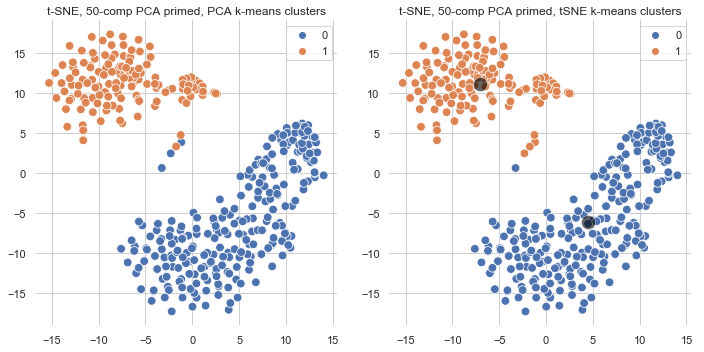

In [14]:
# plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(tSNE_results[:,0], tSNE_results[:,1], s=75, hue=clusters)
plt.title('t-SNE, 50-comp PCA primed, PCA k-means clusters')

plt.subplot(122)
sns.scatterplot(tSNE_results[:,0], tSNE_results[:,1], s=75, hue=clusters_tSNE)
sns.scatterplot(cluster_fit_tSNE.cluster_centers_[:,0], cluster_fit_tSNE.cluster_centers_[:,1], s=200, alpha=0.6, color='black')
plt.title('t-SNE, 50-comp PCA primed, tSNE k-means clusters')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Look at DCA results
DCA was performed on same data as above from terminal with the following command:  
```
dca little_test_labels.csv DCA_results
```

In [15]:
# get output from DCA. should be in 32-dimensional space
reduced = np.ndfromtxt('DCA_results/reduced.tsv')
reduced.shape

(375, 33)

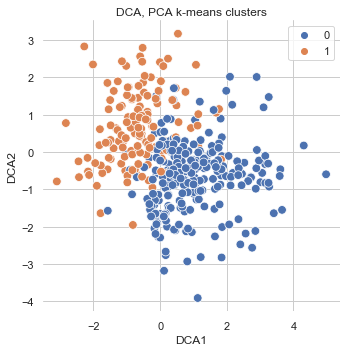

In [16]:
# plot first two dimensions of DCA, colored by clusters from PCA/KMeans above
plt.figure(figsize=(5,5))
sns.scatterplot(reduced[:,1],reduced[:,2],s=75,hue=clusters)
plt.title('DCA, PCA k-means clusters')
plt.xlabel('DCA1')
plt.ylabel('DCA2')

sns.despine(left=True, bottom=True)
plt.tight_layout()

Looks like you could visualize this reduction with a t-SNE plot.  
Perform t-SNE as before, using DCA to prime instead of PCA.

In [17]:
# This uses perplexity=30 (default) and random initialisation
%time tSNE_DCA_results = TSNE(n_components=2).fit_transform(reduced[:,1:])
# resulting matrix should be (375,2)
tSNE_DCA_results.shape

CPU times: user 1.54 s, sys: 4.26 ms, total: 1.55 s
Wall time: 1.55 s


(375, 2)

In [18]:
# cluster tSNE results using k-means
cluster_fit_tSNE_DCA = KMeans(n_clusters=2).fit(tSNE_DCA_results)
clusters_tSNE_DCA = cluster_fit_tSNE_DCA.predict(tSNE_DCA_results)

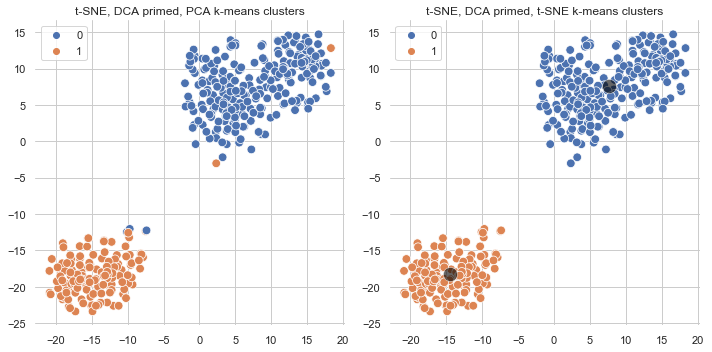

In [19]:
# plot results
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(tSNE_DCA_results[:,0], tSNE_DCA_results[:,1], s=75, hue=clusters)
plt.title('t-SNE, DCA primed, PCA k-means clusters')

plt.subplot(122)
sns.scatterplot(tSNE_DCA_results[:,0], tSNE_DCA_results[:,1], s=75, hue=clusters_tSNE_DCA)
sns.scatterplot(cluster_fit_tSNE_DCA.cluster_centers_[:,0], cluster_fit_tSNE_DCA.cluster_centers_[:,1], s=200, alpha=0.6, color='black')
plt.title('t-SNE, DCA primed, t-SNE k-means clusters')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Evaluate Distance Preservation in Each Technique
Comparing raw counts (un-normalized) to the transformed, dimensionally-reduced data

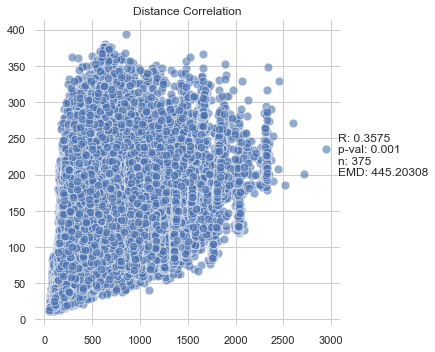

In [20]:
# test for Mantel correlation value and EMD in PCA compared to raw counts
mantel_PCA, EMD_PCA = compare_euclid(pre = r00['Close_0.00'], post = PCA_results)

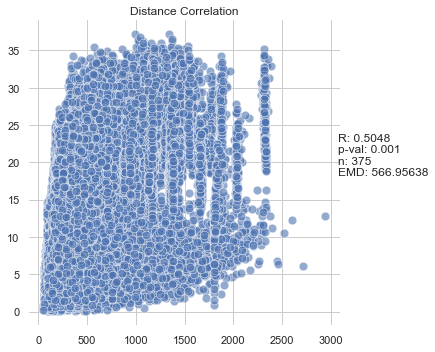

In [21]:
# test for Mantel correlation value and EMD in PCA-primed t-SNE compared to raw counts
mantel_tSNE, EMD_tSNE = compare_euclid(pre = r00['Close_0.00'], post = tSNE_results)

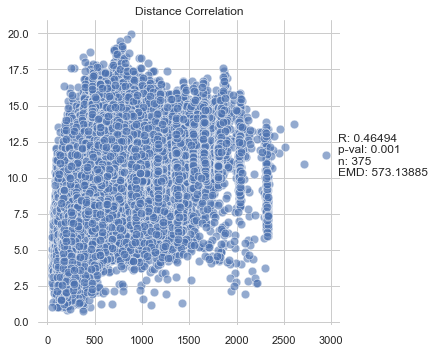

In [22]:
# test for Mantel correlation value and EMD in DCA compared to raw counts
mantel_DCA, EMD_DCA = compare_euclid(r00['Close_0.00'], reduced[:,1:]) # ignore first column in reduced, contains rownames

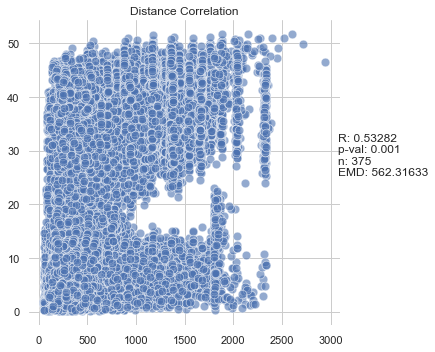

In [23]:
# test for Mantel correlation value and EMD in DCA-primed t-SNE compared to raw counts
mantel_DCA_tSNE, EMD_DCA_tSNE = compare_euclid(r00['Close_0.00'], tSNE_DCA_results)

---
---
TODO:  
* Build clustering function with __`sklearn`__ to cluster based on Euclidean distances between cells in __raw data__
* Build clustering function with __`sklearn`__ that will determine optimal number of clusters in __2D projection__ based on __silhouette score__
* Use this function to cluster data after processing through "gold standard" (probably *arcsinh -> PCA -> t-SNE*)
* Perform reductions using other packages (i.e. DCA, scVI, UMAP), then feed to t-SNE and cluster to determine degree to which other algorithms distort relationships in data
* Extend to other datasets

---
---
Questions:
* Why does KMeans clustering not work on __1st and 2nd principal components__?
* __How many PCs__ are optimal for any given dataset? Should all variability be "explained" by the number of features included?